#### Importing necessary libraries

In [1]:
import pandas as pd     # Data Wrangling & Preprocessing
import numpy as np      # Data Wrangling & Preprocessing
import seaborn as sns   # Plotting charts
import matplotlib.pyplot as plt    # Plotting charts
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split    #Splitting the data into training & testing set 
from sklearn.preprocessing import OneHotEncoder    #Encoding categorical variables
from sklearn.pipeline import Pipeline    # To create pipelines for preprocessing steps
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression    # Linear Regression Model
from sklearn.ensemble import RandomForestRegressor   # RandomForest Regressor Model
from sklearn.metrics import mean_squared_error    # RMSE Evaluation Metric for Regression 
from sklearn.model_selection import cross_val_score    # To Compute validation score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
import pickle    # To export the trained model

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

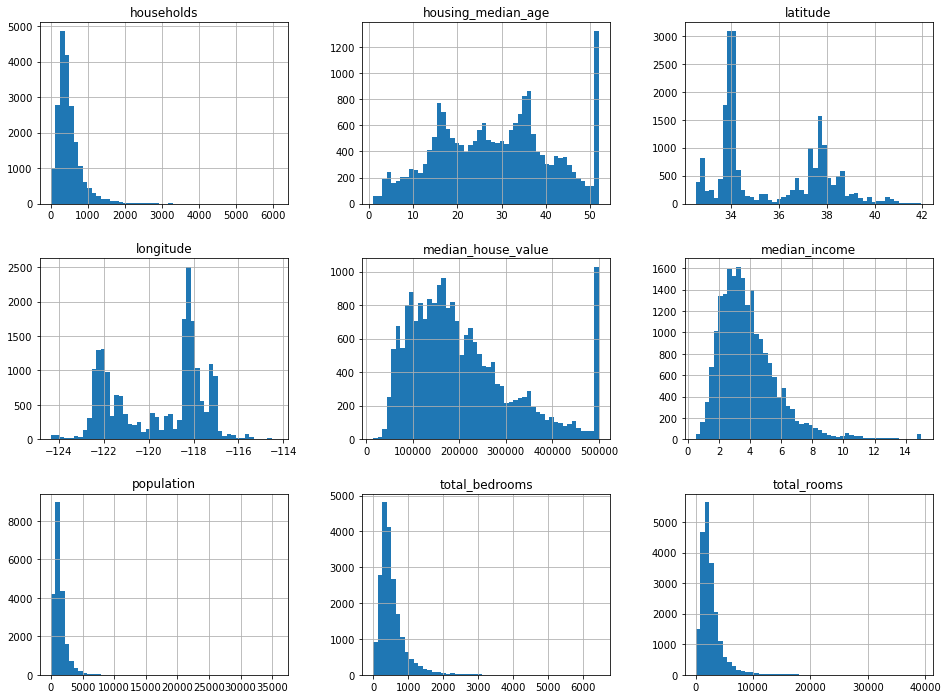

In [5]:
data.hist(bins=50, figsize=(16,12))
plt.show()

##### Split the data into Training and Testing set

In [6]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

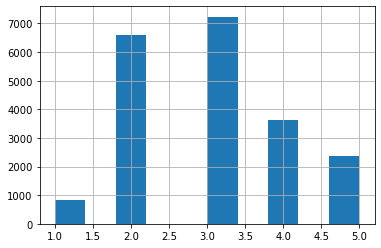

In [7]:
data['income_cat'] = pd.cut(data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
data['income_cat'].hist()
plt.show()

##### Stratified Sampling on Dataset

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [9]:
#Now we need to remove the Income_cat attribute added by us to get the data back to its form:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
data = strat_train_set.copy()

In [10]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


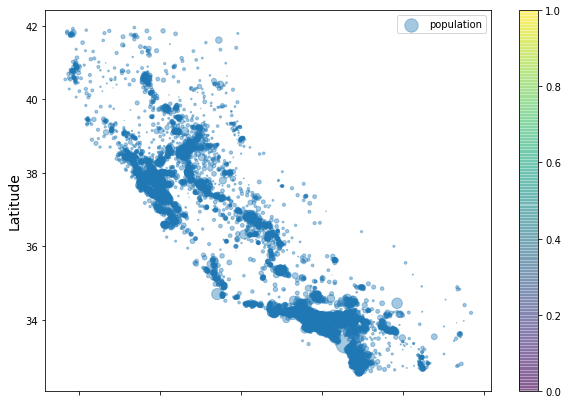

In [11]:
#Now before creating a machine learning model for house price prediction with Python let’s visualize the data in terms of longitude and latitude:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
                s=data['population']/100, label='population', figsize=(10,7),
                cmap=plt.get_cmap('jet'), colorbar=True)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

The graph shows house prices in California where red is expensive, blue is cheap, larger circles indicate areas with a larger population.

#### Finding Correlations

In [12]:
corr_matrix = data.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


In [13]:
data["rooms_per_household"] = data["total_rooms"]/data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"]
data["population_per_household"] = data["population"]/data["households"]

corr_matrix = data.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


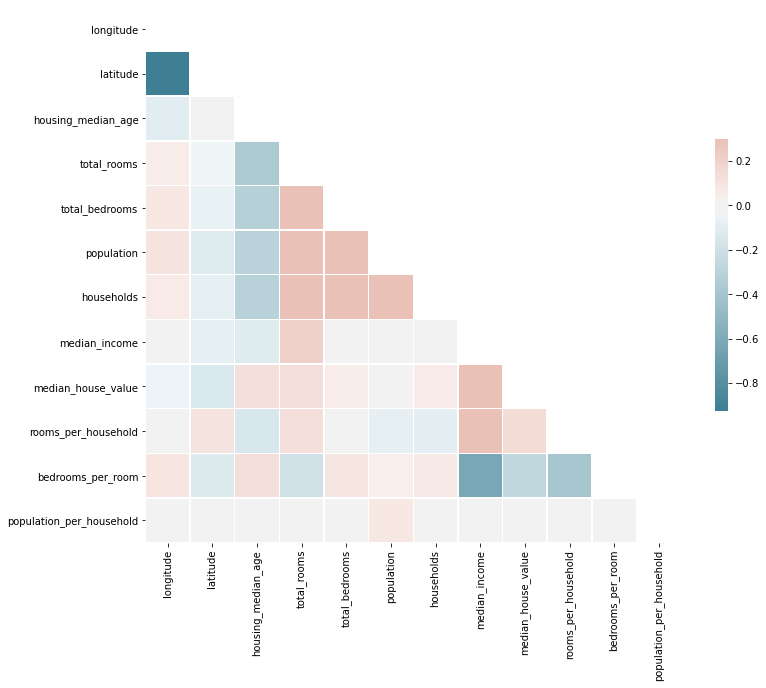

In [14]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Data Preparation

In [15]:
# Data Preparation
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=1)

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [16]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [17]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)


In [19]:
# function to display scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

### Linear Regression for House Price Prediction

In [20]:
# Model Training - LR
lin_reg_model = LinearRegression()
lin_reg_model.fit(housing_prepared, housing_labels)

data = housing.iloc[:5]
labels = housing_labels.iloc[:5]
data_preparation = full_pipeline.transform(data)

In [21]:
# Predictions and RMSE
housing_predictions = lin_reg_model.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE value for Linear Regression: ', lin_rmse)

RMSE value for Linear Regression:  68628.19819848923


In [22]:
#Cross Validation
scores = cross_val_score(lin_reg_model, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()
display_scores(scores)

Scores:  [-4.45993415e+09 -4.48365741e+09 -4.94883441e+09 -5.58600340e+09
 -4.62823518e+09 -5.06856312e+09 -4.22105290e+09 -4.66237845e+09
 -5.11981974e+09 -4.57856587e+09]
Mean:  -4775704463.202971
Standard Deviation:  381684974.0456826


### Random Forest Regressor

In [23]:
# Model Training - RFR
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [24]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE value for Random Forest Regressor: ', forest_rmse)

RMSE value for Random Forest Regressor:  18603.515021376355


In [25]:
# Cross Validation
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean:  50182.303100336096
Standard Deviation:  2097.0810550985693


### Conclusion

Root mean Square error of Random Forest Regressor(RFS) is less than linear regression(LR). So, RFS would be more efficeint for this given data(CSV file).